# Comparing all models with a testing dataset

In [24]:
#import dependencies
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import json
import operator
from PIL import Image, ImageDraw
import albumentations as albu
import pickle
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib as mpl
from scipy.interpolate import make_interp_spline
from distinctipy import distinctipy
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smpu
import random

In [2]:
test_file = '/scratch/ndillenb/notebooks/Hand-Segmentation/Hands_dataset/test_data.udt.json'
test_img = "test_set"
    
x_hands_data = os.path.join('Hands_dataset',test_file)
y_hands_data = os.path.join('Hands_dataset',test_img)

all_dataset = '/scratch/ndillenb/extract_skematic/all_images'

## Loading data

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'



In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

In [6]:
class Dataset(BaseDataset):
    CLASSES = ['__background__', 'hand']
    def __init__(self, 
        data_img,
        data_file,  
        images_dir,
        classes=None, 
        transformation=None, 
        preprocessing=None,):
        
        self.root = 'Hands_dataset'
        self.folder = images_dir
        
        self.ids = data_img
        self.images_fps = data_img
        self.masks_fps = data_file
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.transformation = transformation
        self.preprocessing = preprocessing
    def __getitem__(self, idx):
        # load images and masks
        #print('Image : ' + self.images_fps[idx])
        img_path = os.path.join(self.root, self.folder, self.images_fps[idx])
        img_out = cv2.imread(img_path)
        img_out = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
        idx_mask = 0
        for i in range(len(self.masks_fps)):
            if self.masks_fps[i]['imageUrl'].split("\\")[-1]==self.images_fps[idx]:
                idx_mask = i
                break
        mask_json = self.masks_fps[idx_mask]
        h,w,t = img_out.shape
        all_polygon = []
        im = Image.new("L", (w,h), 0)
        #print('Mask : '+self.masks_fps[idx_mask]['imageUrl'].split("\\")[-1])
        for shape in mask_json['annotation']:
            polygon = tuple()
            for point in shape['points']:
                new_x = point['x']*w
                new_y = point['y']*h
                point = tuple([new_x,new_y])
                polygon=polygon+point
            all_polygon.append(polygon)
            ImageDraw.Draw(im).polygon(polygon, outline=1,fill=1)
        mask = np.array(im)
        mask = mask[...,np.newaxis]
        mask = np.stack(mask, axis=0).astype('int')
        image = img_out
        # apply augmentations
        if self.transformation:
            sample = self.transformation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        #print('['+str(idx)+'] image shape : ' + str(image.shape))
        #print('['+str(idx)+'] mask shape : ' + str(mask.shape))
        return image, mask

    def __len__(self):
        return len(self.ids)

In [23]:
#functions to resize the data
def get_training_transformation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.LongestMaxSize(max_size=160, interpolation=1, always_apply=True, p=1),
        albu.PadIfNeeded(min_height=160,min_width=160,always_apply=True, border_mode=1)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        albu.LongestMaxSize(max_size=160, interpolation=1, always_apply=True, p=1),
        albu.PadIfNeeded(min_height=160,min_width=160,always_apply=True, border_mode=1)        
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
ENCODER = 'resnext101_32x8d'
ENCODER_WEIGHTS = 'instagram'
CLASSES = ['hand']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [10]:
def apply_permutation(list1, list2):
    indices = list(range(len(list1)))  # Generate a list of indices
    random.shuffle(indices)  # Shuffle the indices randomly
    
    permuted_list1 = [list1[i] for i in indices]  # Apply permutation to list1
    permuted_list2 = [list2[i] for i in indices]  # Apply permutation to list2
    
    return permuted_list1, permuted_list2

In [12]:
hands_data_mask = json.load(open(x_hands_data))
hands_data_mask = list(sorted(hands_data_mask['samples'],  key=operator.itemgetter('imageUrl')))
hands_data_img = list(sorted(os.listdir(y_hands_data)))
hands_data_mask, hands_data_img = apply_permutation(hands_data_mask,hands_data_img)

test_mask = hands_data_mask[0:len(hands_data_mask)]
test_img = hands_data_img[0:len(hands_data_img)]
test_mask, test_img = apply_permutation(test_mask,test_img)

In [13]:
test_dataset = Dataset(
    test_img, 
    test_mask, 
    all_dataset,
    transformation=get_training_transformation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)
test_loader = DataLoader(test_dataset, batch_size=1,shuffle=False, num_workers=1)

# Test all models

In [14]:
objects = []
path = '/scratch/ndillenb/trained_model_saved/' #Path of every saved models

In [15]:
def get_pref_array(model,test_dataset): #return y_pref and y
    predictions_arrays = []
    labels_array = []
    b_model = torch.load(model)
    for i in range(len(test_dataset)):
        label = test_dataset[i][1]
        image = test_dataset[i][0]
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        prediction = b_model.predict(x_tensor)
        prediction = (prediction.squeeze().cpu().numpy())
        predictions_arrays.append(prediction)
        labels_array.append(label)
    del b_model
    return predictions_arrays, labels_array

def get_scores(predictions_arrays_stacked_tensor,labels_array_stacked_tensor,THRESHOLD): #compute scores
    tp, fp, fn, tn = smp.metrics.get_stats(predictions_arrays_stacked_tensor, labels_array_stacked_tensor, mode='binary', threshold=THRESHOLD)
    iou_score_micro = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
    iou_score_micro_iw = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise").item()
    f1_score_micro = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro").item()
    f1_score_micro_iw = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro-imagewise").item()
    f2_score_micro = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro").item()
    f2_score_micro_iw = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=2, reduction="micro-imagewise").item()
    f3_score_micro = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=3, reduction="micro").item()
    f3_score_micro_iw = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=3, reduction="micro-imagewise").item()
    f4_score_micro = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=4, reduction="micro").item()
    f4_score_micro_iw = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=4, reduction="micro-imagewise").item()
    f5_score_micro = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=5, reduction="micro").item()
    f5_score_micro_iw = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=5, reduction="micro-imagewise").item()
    f6_score_micro = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=6, reduction="micro").item()
    f6_score_micro_iw = smp.metrics.fbeta_score(tp, fp, fn, tn, beta=6, reduction="micro-imagewise").item()
    accuracy_micro = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro").item()
    accuracy_micro_iw = smp.metrics.accuracy(tp, fp, fn, tn, reduction="micro-imagewise").item()
    recall_micro = smp.metrics.recall(tp, fp, fn, tn, reduction="micro").item()
    recall_micro_iw = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise").item()
    precision_micro = smp.metrics.precision(tp, fp, fn, tn, reduction="micro").item()
    precision_micro_iw = smp.metrics.precision(tp, fp, fn, tn, reduction="micro-imagewise").item()
    fpr_micro = smp.metrics.false_positive_rate(tp, fp, fn, tn, reduction="micro").item()
    fpr_micro_iw =smp.metrics.false_positive_rate(tp, fp, fn, tn,reduction="micro-imagewise").item()#, reduction="micro-imagewise"))
    recall_iw = smp.metrics.recall(tp, fp, fn, tn,reduction="micro-imagewise").item()
    return {'iou_micro': iou_score_micro, 'iou_micro_iw': iou_score_micro_iw, 'f1_score_micro': f1_score_micro, 'f1_score_micro_iw':f1_score_micro_iw,'f2_score_micro':f2_score_micro,'f2_score_micro_iw':f2_score_micro_iw,'f3_score_micro':f3_score_micro,'f3_score_micro_iw':f3_score_micro_iw,'f4_score_micro':f4_score_micro,'f4_score_micro_iw':f4_score_micro_iw,'f5_score_micro':f5_score_micro,'f5_score_micro_iw':f5_score_micro_iw,'f6_score_micro':f6_score_micro,'f6_score_micro_iw':f6_score_micro_iw,'accuracy_micro':accuracy_micro,'accuracy_micro_iw':accuracy_micro_iw,'recall_micro':recall_micro,'recall_micro_iw':recall_micro_iw,'precision_micro':precision_micro,'precision_micro_iw':precision_micro_iw,'fpr_micro':fpr_micro,'fpr_micro_iw':fpr_micro_iw}


In [ ]:
import matplotlib.colors as mcolors
name_model = []
all_scores = []
loss = []
loss2 = []
last_date = []

for root, dirs, files in os.walk(path):
    for name in files:
        if name == 'validation_logs.pickle':
            print(root)
            if 'BINARY' in root:
                break
            if os.path.exists(os.path.join(root,'best_model.pth')):
                predictions_arrays, labels_array = get_pref_array(os.path.join(root,'best_model.pth'),test_dataset)
                last_date.append(os.path.getmtime(os.path.join(root,'best_model.pth')))
            else:
                predictions_arrays, labels_array = get_pref_array(os.path.join(root,'model.pth'),test_dataset)
                last_date.append(os.path.getmtime(os.path.join(root,'model.pth')))
            labels_array_stacked_tensor = torch.from_numpy(np.stack(labels_array, axis=0)).to(torch.int32)
            predictions_arrays_stacked_tensor = torch.from_numpy(np.stack(np.expand_dims(predictions_arrays, axis=1), axis=0))
            all_scores.append(get_scores(predictions_arrays_stacked_tensor,labels_array_stacked_tensor,0.9))
            path1 = root
            info = []
            for i in range(6):
                split_path = os.path.split(path1)
                path1 = split_path[0]
                info.append(split_path[1])
            name_model.append(info)

In [17]:
#save metrics as this can be a time consuming process
data = {'name_model': name_model, 'all_scores': all_scores}
with open('metrics_all_stats_4.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
dataset = ['hands_only', 'smaller_dataset','half_data','all_data','all_data+hands_only','smaller_dataset+all_data','half_split_test_val_distribution','half_split_test_val_distribution(50-3-3)-(80-10-10)','half_split_test_val_distribution(33-3-3)-(80-10-10)','half_split_test_val_distribution(10-3-3)-(80-10-10)','half_split_test_val_distribution(70-3-3)-(80-10-10)']
cmap = plt.get_cmap('tab10')
color = [mcolors.to_hex(cmap(i)) for i in np.linspace(0, 1, len(dataset))]
colors = []
x = range(len(name_model))
Architecture = []
Encoder = []
Encoder_weight = []
Loss = []
Dataset = []
Comment = []
Date = []
for i in x:
    Comment.append(name_model[i][0])
    Dataset.append(name_model[i][1])
    colors.append(color[dataset.index(name_model[i][1])])
    Loss.append(name_model[i][2])
    Encoder_weight.append(name_model[i][3])
    Encoder.append(name_model[i][4])
    Architecture.append(name_model[i][5])
    Date.append(last_date[i])

In [25]:
cat = list(range(len(name_model)))
s = np.zeros((len(list(all_scores[0].values())),len(cat)))
for i in range(0,len(cat)):
    for j in range(len(list(all_scores[i].values()))):
        s[j][i]=list(all_scores[i].values())[j]
b = np.transpose(s)
def plot_all():#HERE ITS NOT THE SAME INDEX
    for i in range(len(list(all_scores[i].values()))):
        plt.figure(figsize=(10,6))
        plt.bar(cat, s[i])
        plt.xticks(cat)
        # Adding labels and title
        plt.xlabel('Threshold')
        plt.ylabel('Value')
        plt.ylim((0,1))
        plt.title(list(all_scores[0].keys())[i])
        # Displaying the plot
        plt.show()
    return

df = pd.DataFrame({
    "Architecture": Architecture,
    "Encoder" : Encoder,
    "Encoder Weight" : Encoder_weight,
    "Loss " : Loss,
    "Dataset" : Dataset,
    "Comment" : Comment,
    "iou" : s[0],
    "iou_iw" : s[1],
    "f1":s[2],
    "f1_iw":s[4],
    "f2": s[5],
    "f2_iw": s[6],
    "accuracy" : s[14],
    "accuracy_iw" : s[15],
    "recall": s[16],
    "recall_iw" : s[17],
    "precision": s[18],
    "precision_iw" : s[19],
    "fpr": s[20],
    "fpr_iw": s[21],
    "date":Date
})
df.style \
  .format(precision=3, thousands=".", decimal=",") \
  .format_index(str.upper, axis=1) 

df_sorted = df.sort_values(by=['date']).reset_index(drop=True)
display(df_sorted)

,Architecture,Encoder,Encoder Weight,Loss,Dataset,Comment,iou,iou_iw,f1,f1_iw,...,f2_iw,accuracy,accuracy_iw,recall,recall_iw,precision,precision_iw,fpr,fpr_iw,date
0,Unet,resnext101_32x16d,instagram,Diceloss,hands_only,epoch500_lr_4.11E-06,0.278197,0.981041,0.435296,0.448484,...,0.453059,0.999162,0.999162,0.457728,0.989100,0.414960,0.987759,0.000456,0.000475,1.682761e+09
1,PSPNet,resnext101_32x8d,instagram,Diceloss,hands_only,epoch500_lr_4.11E-06,0.048419,0.875979,0.092365,0.155960,...,0.202415,0.996029,0.996029,0.288286,0.987075,0.054992,0.882109,0.003475,0.003485,1.682928e+09


# plot subset

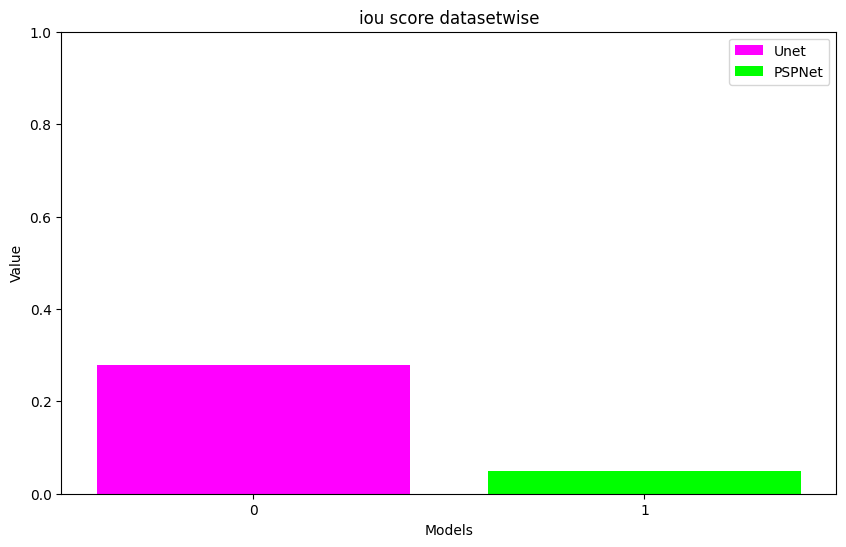

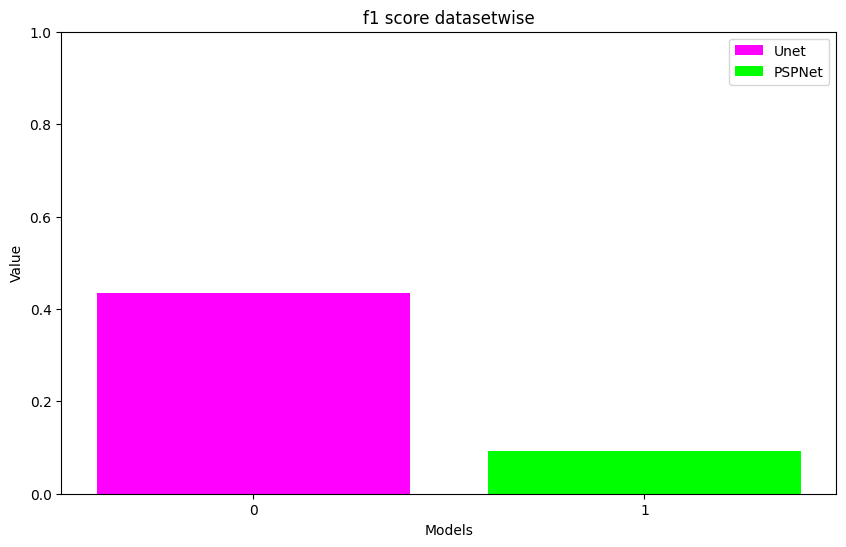

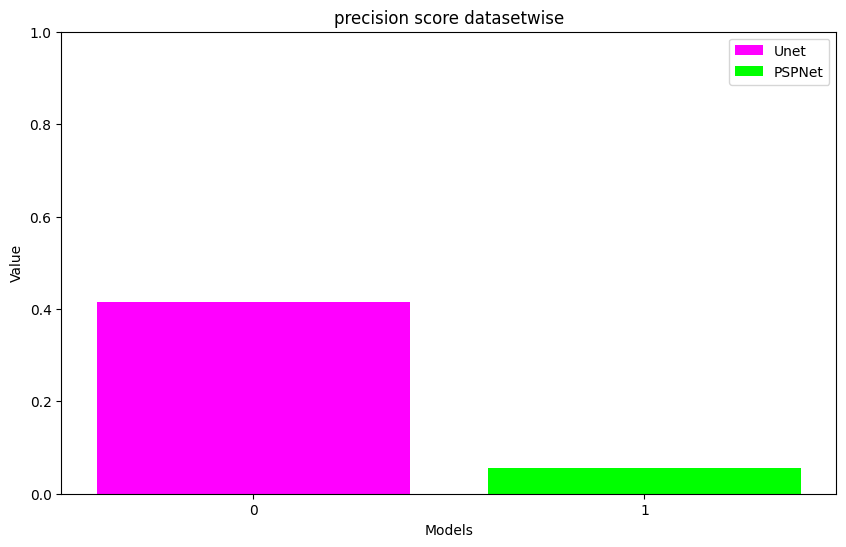

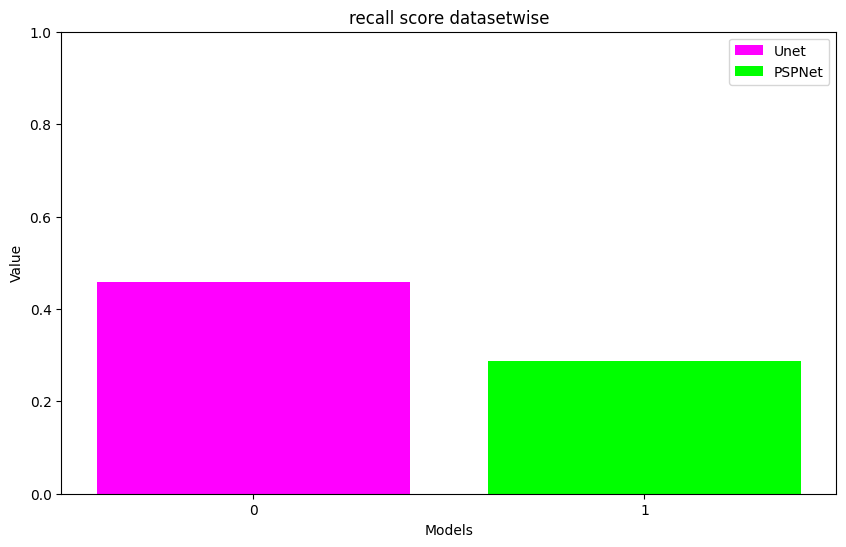

In [26]:
models_to_plot = [0,1] #select a few models to compare (with index)
label_to_plot='Architecture' #One of the column name to plot
cat_a_name = list(map(str, models_to_plot))
append_labels = []
append_colors = []
if label_to_plot!='':
    unique = np.unique(df_sorted.loc[models_to_plot][label_to_plot].values)
    color_i = distinctipy.get_colors(len(unique))
    for item in df_sorted.loc[models_to_plot][label_to_plot].values:
        if item in append_labels:
            idx = np.where(unique==item)
            append_colors.append(color_i[idx[0][0]])
            append_labels.append('')
        else:
            append_labels.append(item)
            idx = np.where(unique==item)
            append_colors.append(color_i[idx[0][0]])


def metric_plot(metric, cat_title,df,models_to_plot,labels,colors):
    plt.figure(figsize=(10,6)) 
    color_i = distinctipy.get_colors(len(np.unique(label_to_plot)))
    plt.bar(cat_title, df.loc[models_to_plot][metric].values,color = colors,label=labels)
    # Adding labels and title
    plt.xlabel('Models')
    plt.ylabel('Value')
    plt.ylim((0,1))
    plt.title(metric + " score datasetwise")
    # Displaying the plot
    plt.legend()
    plt.show()
    return
metric_plot("iou",cat_a_name,df_sorted,models_to_plot,append_labels, append_colors)
metric_plot("f1",cat_a_name,df_sorted,models_to_plot,append_labels, append_colors)
metric_plot("precision",cat_a_name,df_sorted,models_to_plot,append_labels, append_colors)
metric_plot("recall",cat_a_name,df_sorted,models_to_plot,append_labels, append_colors)